In [1]:
import sys
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

sys.path.append('..')
sys.path.append('../classes/')
sys.path.append('../data/')
sys.path.append('../model_weights/')

from utilities import *
from classes.ClockDataset import *
from classes.MinutesDistance import *
from classes.Models import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


<h4>Load data and labels</h4>

data: torch.Size([18000, 1, 150, 150]), labels: torch.Size([18000, 2])


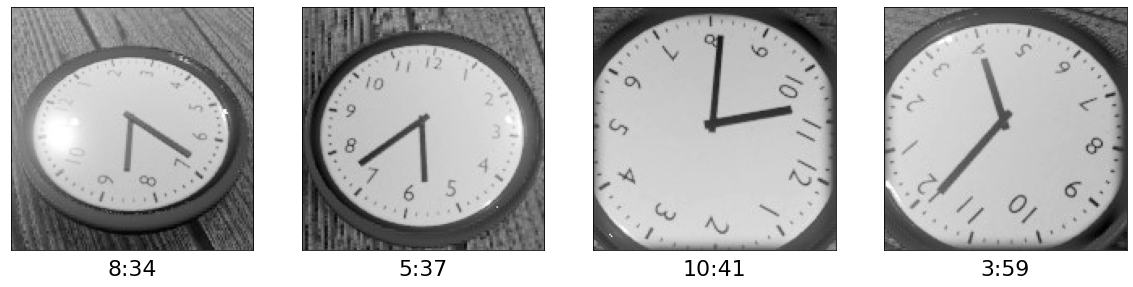

In [2]:
# Load data and add sine and cosine transform to labels
data, labels = load_data('../data')
print(f"data: {data.shape}, labels: {labels.shape}")

# Choose image samples for plots
samples = []
sample_labels = []
for i in range(4):
    label = i+2550
    sample_labels.append(str(int(labels[label][0].item()))+":"+str(int(labels[label][1].item())))
    img_arr = (data[label].numpy().squeeze(axis=0)*255).astype(np.uint8)
    samples.append(img_arr)

# Plot image samples
font = {'size': 22}
plt.rc('font', **font)
fig, axis = plt.subplots(1,4, figsize=(20,12))
for i in range(4):
    axis[i].imshow(samples[i], cmap="gray")
    axis[i].set_xlabel(sample_labels[i], labelpad=10)
for ax in axis:
    ax.set_xticks([])
    ax.set_yticks([])

<h4>Dataset Creation</h4>

In [3]:
# split test set as to not apply data augmentation
test_data, test_labels = data[:500,:], labels[:500,:]
data, labels = data[500:,:], labels[500:,:]

# Create main dataset
clock_dataset = ClockDataset(data, labels, transform=True)
clock_test_datset = ClockDataset(test_data, test_labels, 
                                transform=False)

train_data, val_data = random_split(clock_dataset, 
                                    [16500,1000])
# Split dataset into train, test and validation sets
train_data_loader = DataLoader(train_data, batch_size=64)
val_data_loader = DataLoader(val_data, batch_size=64)
test_data_loader = DataLoader(clock_test_datset, batch_size=64)


# print shapes of batches (channels first)
for X, y in train_data:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 150, 150])
Shape of y: torch.Size([2]) torch.float32


<h4>Model creation</h4>

In [4]:
model = NN_regression(input_channels=1,h=150,w=150, n_outputs=2).to(device)
loss = MinutesDistance()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

<h4>Main model training step</h4>

In [5]:
epochs = 200
patience = 10
weights_name = None
approach = "cse_loss"

# Main training loop
curr_patience = 0
train_losses = []
eval_losses = []
mean_test_loss = np.inf
print("\n~~~Starting training~~~\n")
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Training step
    train_l = train(train_data_loader, model, loss, 
                    optimizer, device, approach)
    train_mean = torch.mean(train_l)
    train_losses.append(train_mean)
    print(f"Training loss: {train_mean:>7f}")

    # Evaluation step
    eval_l = evaluate(val_data_loader, model, loss, device, approach)
    eval_mean = torch.mean(eval_l)
    eval_losses.append(eval_mean)
    print(f"Evaluation loss: {eval_mean:>8f}")

    # Save new weights if they are better
    if eval_mean < mean_test_loss:
        curr_patience = 0
        if weights_name != None: 
            print("Saving new best weights.")
            mean_test_loss = eval_mean
            torch.save(model.state_dict(), "model_weights/"+weights_name)
    print()

    # Stop training if patience expired
    if curr_patience >= patience:
        print(f"No new best weights found after {patience} iterations.")
        break
    curr_patience += 1  # increment patience if new best not found

end_time = time.time()
print(f"Training finished in {np.round(end_time-start_time, 3)} seconds.")


~~~Starting training~~~

Epoch 1
-------------------------------
Training loss: 194.612381
Evaluation loss: 190.659958

Epoch 2
-------------------------------
Training loss: 192.776505
Evaluation loss: 183.561325

Epoch 3
-------------------------------
Training loss: 193.063339
Evaluation loss: 193.471481

Epoch 4
-------------------------------
Training loss: 195.279785
Evaluation loss: 194.710739

Epoch 5
-------------------------------
Training loss: 195.590103
Evaluation loss: 195.573822

Epoch 6
-------------------------------
Training loss: 195.568283
Evaluation loss: 197.266022

Epoch 7
-------------------------------
Training loss: 195.149567
Evaluation loss: 197.207428

Epoch 8
-------------------------------
Training loss: 194.937668
Evaluation loss: 197.207428

Epoch 9
-------------------------------
Training loss: 194.782501
Evaluation loss: 197.207428

Epoch 10
-------------------------------
Training loss: 194.564163
Evaluation loss: 193.418747

Epoch 11
--------------

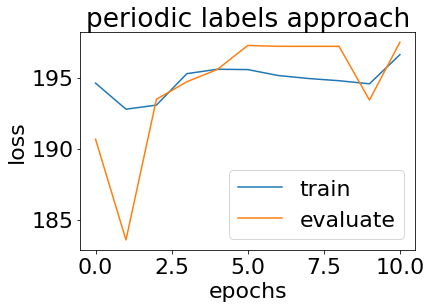

In [6]:
# Plot losses
train_losses = np.vstack(train_losses)
test_losses = np.vstack(eval_losses)

plt.plot(train_losses, label="train")
plt.plot(test_losses, label="evaluate")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("periodic labels approach")
plt.show()

In [7]:
# make predictions
predictions = predict(test_data_loader, model, loss, device, approach)

# calculate and print common sense error
cse = MinutesDistance()
mins_dist = cse.minutes_loss(torch.FloatTensor(predictions),
                            torch.FloatTensor(test_labels))

print(f"Common sense error on test dataset: {np.round(mins_dist.numpy(),3)}")

Avg evaluation loss of best weights: 201.290115 

Common sense error on test dataset: 201.77200317382812
